# Project 4: Fuel Monitoring System Design
>**Date Created**: 21 February 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import sympy as smp
from scipy.linalg import expm, solve_discrete_are

In [26]:
# Read in data and label columns
data = r'fuel_data.csv'
df = pd.read_csv(data,header=None)
columnMapper = dict(
    zip(
        df.columns.values,
        ["t", "u_k", "y_k","f_k","b_k"],
    )
)
df = df.rename(columns=columnMapper)
df = df.fillna(5)
df.head()

,t,u_k,y_k,f_k,b_k
0,0.0,8.712638,5.000000,3200.000000,0.050000
1,0.5,13.283346,22.450033,3195.676728,0.099930
2,1.0,3.195561,21.643693,3189.054264,0.005879
3,1.5,8.187671,19.818694,3187.447473,-0.038837
4,2.0,13.939558,19.719150,3183.364968,0.013155


In [27]:
meas_vec = df[['u_k', 'y_k']].to_numpy()

In [105]:
dt = 0.5 
Aline = 1 
Atank = 150
F = np.array([[1, Aline*dt],
             [0, 1]])
G = np.array([-Aline * dt, 0]).reshape(2,1)
H = np.array([1/Atank, 0])
P0 = np.diag([10**2, 0.1**2])
Q = np.diag([Aline**2 * dt**2 * 0.1**2, 0.1**2])
R = 1**2
x0 = np.array([5000, 0]).reshape(2,1)

In [146]:
dt = 0.5 
Aline = 1 
Atank = 150
F = np.array([[1, Aline*dt],
             [0, 1]])
G = np.array([-Aline * dt, 0])
H = np.array([1/Atank, 0])
P0 = np.diag([10**2, 0.1**2])
Q = np.diag([Aline**2 * dt**2 * 0.1**2, 0.1**2])
R = 1**2
x0 = np.array([3000, 0])

In [147]:
Fd = expm(F)
Gd = (Fd - np.eye(2)) @ G
Rd = R/dt

In [186]:
def predict(z, x, P, F, G, Q):
    x_k_km1 = np.dot(F, x) + np.dot(G, z[0])
    P_k_km1 = np.dot(F,P).dot(F.T) + Q
    return x_k_km1, P_k_km1

def update(z, x, P, H, R):
    y_innov = z[1] - np.dot(H,x)
    S = np.dot(H, P)
    K = np.dot(P,H.T) * 1/S
    x_k_k = x - np.dot(K, y_innov)
    print(x_k_k)
    P_k_k = (np.eye(2) - np.dot(K,H)).dot(P)
    return x_k_k, P_k_k

In [14]:
res = np.zeros((600, 2))
for k in range(600):
    current_meas = meas_vec[0]
    if k == 0:
        x = x0
        P = P0
        res[k] = x.reshape(2,)
    xhat, Phat = predict(current_meas, x, F, G, Q)
    xu, Pu = update(current_meas, xhat, Phat, H, R)
    x = xu
    P = Pu
    if not k ==0:
        res[k] = x.reshape(2,)

[-14.97095787]
[-14.87566762]
[-14.78107591]
[-14.68716066]
[-14.59389549]
[-14.50124991]
[-14.40918943]
[-14.31767579]
[-14.22666705]
[-14.13611779]
[-14.04597924]
[-13.95619942]
[-13.86672329]
[-13.77749293]
[-13.68844761]
[-13.599524]
[-13.51065631]
[-13.42177639]
[-13.33281395]
[-13.24369666]
[-13.15435034]
[-13.06469908]
[-12.97466548]
[-12.88417075]
[-12.79313494]
[-12.7014771]
[-12.60911547]
[-12.5159677]
[-12.42195107]
[-12.32698265]
[-12.23097958]
[-12.13385929]
[-12.03553973]
[-11.93593964]
[-11.83497877]
[-11.73257819]
[-11.62866055]
[-11.52315032]
[-11.41597414]
[-11.30706108]
[-11.1963429]
[-11.08375441]
[-10.96923374]
[-10.85272263]
[-10.73416672]
[-10.6135159]
[-10.49072455]
[-10.36575182]
[-10.23856195]
[-10.10912451]
[-9.97741463]
[-9.8434133]
[-9.70710754]
[-9.56849062]
[-9.42756224]
[-9.28432872]
[-9.13880308]
[-8.9910052]
[-8.84096187]
[-8.68870688]
[-8.53428097]
[-8.37773191]
[-8.21911436]
[-8.05848987]
[-7.89592674]
[-7.73149984]
[-7.56529049]
[-7.3973862]
[-7.227

In [13]:
def predict(z, x, F, G, Q):
    xhat = np.dot(F, x) + np.dot(G, z[0])
    Phat = F @ P @ F.T + Q
    return xhat, Phat

def update(z, xhat, Phat, H, R):
    inov = z[1] - H @ xhat
    print(inov)
    S = np.dot(H, Phat).dot(H.T) + R
    K = ((Phat @ H.T)/S).reshape(2,1)
    xkp1 = xhat + (K @ inov).reshape(*xhat.shape)
    Pkp1 = (np.eye(2) - np.dot(K, H.reshape(1,2))).dot(Phat)
    return xkp1, Pkp1

In [40]:
res = np.zeros((600, 2))
Ps = np.zeros((2,2,600))
for k in range(600):
    if k == 0: 
        x = x0
        P = P0
        res[k] = x.reshape(2,)
        Ps[:,:,k] = P
    xhat = np.dot(F, x) + np.dot(G, meas_vec[k][0])
    Phat = F @ P @ F.T + Q
    inov = meas_vec[k][1] - H @ xhat
    S = np.dot(H, Phat).dot(H.T) + R
    K = ((Phat @ H.T)/S).reshape(2,1)
    print(K)
    xkp1 = xhat + (K @ inov).reshape(*xhat.shape)
    Pkp1 = (np.eye(2) - np.dot(K, H.reshape(1,2))).dot(Phat)
    x = xkp1
    P = Pkp1
    if not k ==0:
        res[k] = x.reshape(2,)
        Ps[:,:,k] = P
        
    

[[6.63749853e-01]
 [3.31858334e-05]]
[[6.60908155e-01]
 [9.94125408e-05]]
[[6.58173557e-01]
 [1.98537517e-04]]
[[6.55577636e-01]
 [3.30420235e-04]]
[[6.53151572e-01]
 [4.94921883e-04]]
[[0.65092615]
 [0.0006919 ]]
[[0.64893177]
 [0.00092123]]
[[0.64719846]
 [0.00118277]]
[[0.64575587]
 [0.00147637]]
[[0.64463326]
 [0.00180191]]
[[0.64385954]
 [0.00215924]]
[[0.64346324]
 [0.00254822]]
[[0.64347249]
 [0.0029687 ]]
[[0.64391504]
 [0.00342052]]
[[0.64481826]
 [0.00390353]]
[[0.64620908]
 [0.00441757]]
[[0.64811403]
 [0.00496245]]
[[0.65055917]
 [0.00553799]]
[[0.65357012]
 [0.006144  ]]
[[0.65717201]
 [0.00678027]]
[[0.66138943]
 [0.00744657]]
[[0.66624646]
 [0.00814268]]
[[0.67176657]
 [0.00886833]]
[[0.67797264]
 [0.00962324]]
[[0.68488689]
 [0.01040714]]
[[0.69253085]
 [0.01121971]]
[[0.7009253 ]
 [0.01206061]]
[[0.71009025]
 [0.01292947]]
[[0.72004485]
 [0.01382592]]
[[0.7308074 ]
 [0.01474954]]
[[0.74239521]
 [0.01569989]]
[[0.75482462]
 [0.01667649]]
[[0.76811091]
 [0.01767884]]
[[0

In [42]:
res = np.zeros((600, 2))
Ps = np.zeros((2,2,600))
for k in range(600):
    if k == 0: 
        x = x0
        P = P0
        res[k] = x.reshape(2,)
        Ps[:,:,k] = P
    xhat = np.dot(Fd, x) + np.dot(Gd, meas_vec[k][0])
    Phat = Fd @ P @ Fd.T + Q
    inov = meas_vec[k][1] - H @ xhat
    S = np.dot(H, Phat).dot(H.T) + Rd
    K = ((Phat @ H.T)/S).reshape(2,1)
    xkp1 = xhat + (K @ inov).reshape(*xhat.shape)
    Pkp1 = (np.eye(2) - np.dot(K, H.reshape(1,2))).dot(Phat)
    x = xkp1
    P = Pkp1
    if not k ==0:
        res[k] = x.reshape(2,)
        Ps[:,:,k] = P

[2997.54996732           nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


C:\Users\Benjamin Lucke\AppData\Local\Temp\ipykernel_27436\3031914386.py:9: RuntimeWarning: invalid value encountered in divide
  K = np.dot(P,H.T) * 1/S


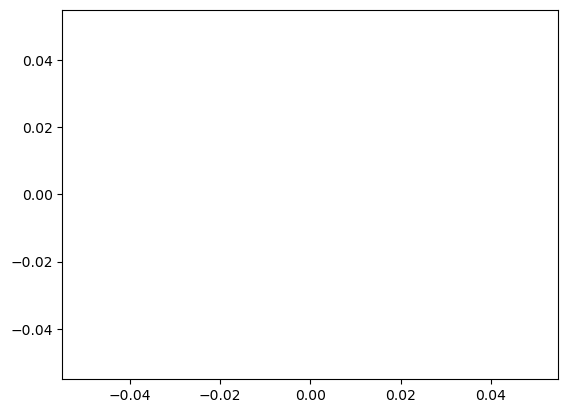

In [187]:
dt = 0.5 
Aline = 1 
Atank = 150
F = np.array([[1, Aline*dt],
             [0, 1]])
G = np.array([-Aline * dt, 0])
H = np.array([1/Atank, 0])
P0 = np.diag([10**2, 0.1**2])
Q = np.diag([Aline**2 * dt**2 * 0.1**2, 0.1**2])
R = 1**2
x0 = np.array([3000, 0])

res = np.zeros((600,2))
for k in range(600):
    if k == 0:
        x = x0
        P = P0
        res[k] = x
        continue
    x_k_km1, P_k_km1 = predict(meas_vec[k], x, P, F, G, Q)
    x_k_k, P_k_k = update(meas_vec[k], x, P, H, R)
    x = x_k_k
    res[k] = x
    P = P_k_k
plt.plot(res[:,1])

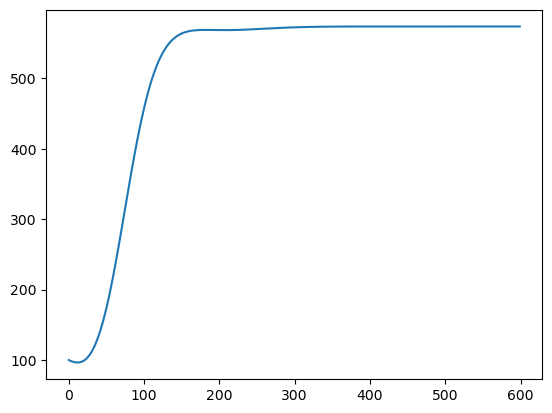

In [24]:
plt.plot(Ps[0,0,:])

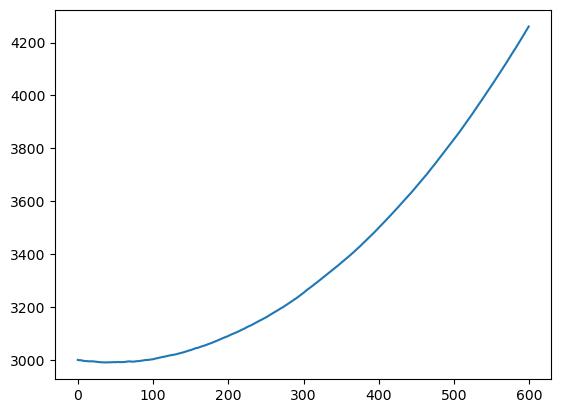

In [145]:
plt.plot(res[:,0])

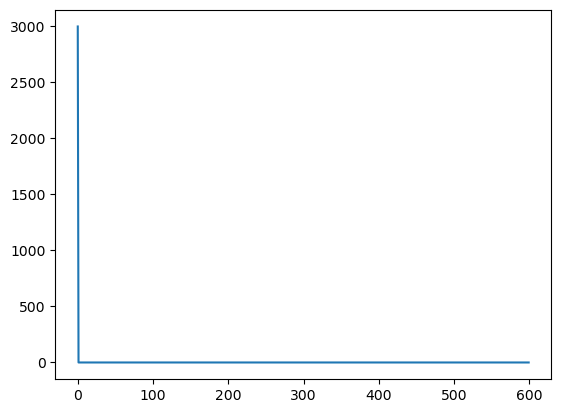

In [134]:
plt.plot(res[:,0])